## Packages

In [22]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset 
from functools import partial

import transformers
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, BertConfig
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig, AdamW

import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, roc_curve, f1_score

## Load Data


In [23]:
raw = pd.read_csv('tsla_dataset.csv', encoding='utf-8', names=['Date', 'News_Headline','label','score'])
raw['label'].replace({'neutral':'Neutral', 'positive':'Positive', 'negative': 'Negative'}, inplace=True)
raw = raw.drop(raw.index[0])
raw2 = raw.copy()
raw2['label'].replace({'Neutral':0, 'Positive':1, 'Negative':2}, inplace=True)
raw2 = raw2[['Date', 'News_Headline','label','score']]
seed = 2024

In [24]:
raw2_new = raw2.drop(columns=['Date', 'score'])
raw2_new

,News_Headline,label
1,Tesla short sellers lost billions more on the ...,2
2,"In 2021, the breadth of the competitive attack...",1
3,"In 2021, the breadth of the competitive attack...",1
4,Elon Musk says it’s “impossible” to take Tesla...,0
5,Elon Musk has made millionaires out of Tesla's...,0
...,...,...
8961,Apple has assigned hundreds of staffers to an ...,0
8962,Apple gears up to challenge Tesla in electric ...,0
8963,Apple has assigned 100s of staffers to an elec...,0
8964,"Apple, Microsoft and Tesla shops are helping h...",0


In [25]:
df_train, df_test, = train_test_split(raw2_new, stratify=raw2_new['label'], test_size=0.1, random_state=seed)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'], test_size=0.1, random_state=seed)
print(df_train.shape, df_test.shape, df_val.shape)

(7261, 2) (897, 2) (807, 2)


In [26]:
val_set = df_val.copy()
test_set = df_test.copy()
test_set = pd.concat([test_set, val_set], axis=0) # 把test和val concat起來
test_set.reset_index(inplace=True, drop = True)
test_set['label'].replace({0:'Neutral', 1:'Positive', 2:'Negative'}, inplace=True)
print(test_set.shape)

(1704, 2)


## Fine-tuned BERT Model

### I. Fine-tuning Process

In [27]:
bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
senti_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/86b5e0934494bd15c9632b12f734a8a67f723594/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /

In [28]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_val = dataset_val.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length', max_length=512), batched=True)
dataset_test = dataset_test.map(lambda e: senti_tokenizer(e['News_Headline'], truncation=True, padding='max_length' , max_length=512), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

Map: 100%|██████████| 897/897 [00:00<00:00, 5019.66 examples/s]


In [29]:
dataset_train

Dataset({
    features: ['News_Headline', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7261
})

In [30]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'f1_score' : f1_score(predictions, labels, average='micro')}

args = TrainingArguments(
        output_dir='temp/',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='f1_score',
)

trainer = Trainer(
        model=bert,                          # the instantiated Transformers model to be trained
        args=args,                           # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [31]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: News_Headline, __index_level_0__. If News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/root/.virtualenvs/tradebot/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 7261
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1135
  Number of trainable parameters = 109484547


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.164764,0.939281
2,No log,0.145523,0.954151
3,0.269600,0.190120,0.955390
4,0.269600,0.177096,0.961586
5,0.036000,0.182298,0.965304


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: News_Headline, __index_level_0__. If News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 807
  Batch size = 32
Saving model checkpoint to temp/checkpoint-227
Configuration saved in temp/checkpoint-227/config.json
Model weights saved in temp/checkpoint-227/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: News_Headline, __index_level_0__. If News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 807
  Batch size = 32
Saving model checkpoint to temp/checkpoint-454
Configuration saved in

TrainOutput(global_step=1135, training_loss=0.13630668738865118, metrics={'train_runtime': 839.1611, 'train_samples_per_second': 43.263, 'train_steps_per_second': 1.353, 'total_flos': 9552332630615040.0, 'train_loss': 0.13630668738865118, 'epoch': 5.0})

In [32]:
bert.eval()
trainer.predict(dataset_test).metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: News_Headline, __index_level_0__. If News_Headline, __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 897
  Batch size = 32


{'test_loss': 0.26003792881965637,
 'test_f1_score': 0.9487179487179487,
 'test_runtime': 6.9566,
 'test_samples_per_second': 128.942,
 'test_steps_per_second': 4.169}

In [33]:
trainer.save_model('BERT_fine_tuned_1')

Saving model checkpoint to BERT_fine_tuned_1
Configuration saved in BERT_fine_tuned_1/config.json
Model weights saved in BERT_fine_tuned_1/pytorch_model.bin


### II. Evaluate the Fine-tuned BERT Model

In [34]:
tuned_bert_model = BertForSequenceClassification.from_pretrained('BERT_fine_tuned_1', id2label={0: 'Neutral', 1: 'Positive', 2: 'Negative'})
senti_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

loading configuration file BERT_fine_tuned_1/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Neutral",
    "1": "Positive",
    "2": "Negative"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file BERT_fine_tune

In [35]:
tuned_bert_model.config.id2label

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [36]:
neutral = list()
positive = list()
negative = list()
for i in range(len(test_set)):
  inputs = senti_tokenizer(test_set.iloc[i, 0], padding=True, truncation=True, max_length=512, return_tensors='pt') #tokenize text to be sent to model
  outputs = tuned_bert_model(**inputs)
  predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
  neutral.append(predictions[0][0].tolist())
  positive.append(predictions[0][1].tolist())
  negative.append(predictions[0][2].tolist())

In [37]:
df_array = np.array(test_set)
df_list = list(df_array[:, 0])
table = {'News_Headline':df_list, "Positive":positive, "Negative":negative, "Neutral":neutral}      
result_ft_BERT = pd.DataFrame(table, columns = ["News_Headline", "Positive", "Negative", "Neutral"])
result_ft_BERT['Prediction'] = result_ft_BERT[['Positive', 'Negative', 'Neutral']].idxmax(axis=1)
result_ft_BERT['label'] = test_set['label'].copy()
result_ft_BERT

,News_Headline,Positive,Negative,Neutral,Prediction,label
0,5 comparably priced alternatives to Tesla's Mo...,0.000312,0.000309,0.999379,Neutral,Neutral
1,New Tesla car registrations in China plunge 46...,0.000579,0.999161,0.000260,Negative,Negative
2,"The burger chain that's ""Tesla for burgers,"" a...",0.000257,0.000545,0.999197,Neutral,Neutral
3,At least one analyst is flagging the Tesla sel...,0.000553,0.999116,0.000331,Negative,Negative
4,Toyota using Tesla-style Panasonic batteries f...,0.000233,0.000310,0.999457,Neutral,Neutral
...,...,...,...,...,...,...
1699,Elon Musk reaffirms Tesla's forecast that the ...,0.999359,0.000386,0.000255,Positive,Positive
1700,Tesla may offer a Roadster option where the ca...,0.000276,0.000221,0.999503,Neutral,Neutral
1701,Tesla value set to jump $40 billion as S&amp;P...,0.999296,0.000506,0.000198,Positive,Positive
1702,"Tesla just released solar roof prices, and the...",0.999210,0.000568,0.000222,Positive,Positive


In [38]:
print(classification_report(result_ft_BERT['label'], result_ft_BERT['Prediction']))

              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94       357
     Neutral       0.97      0.97      0.97      1017
    Positive       0.95      0.93      0.94       330

    accuracy                           0.96      1704
   macro avg       0.95      0.95      0.95      1704
weighted avg       0.96      0.96      0.96      1704



In [39]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """
    Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    :param confusion_matrix: numpy.ndarray, The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
                             Similarly, constructed nd.Arrays can also be used.
    :param class_names: An ordered list of class names, in the order they index the given confusion matrix.
    :param figsize: tuple, A 2-long tuple, the first value determining the horizontal size of the output figure, the second
                    determining the vertical size. Defaults to (10,7).
    :param fontsize: int, Font size for axes labels. Defaults to 14.
    :return: matplotlib.figure.Figure, The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

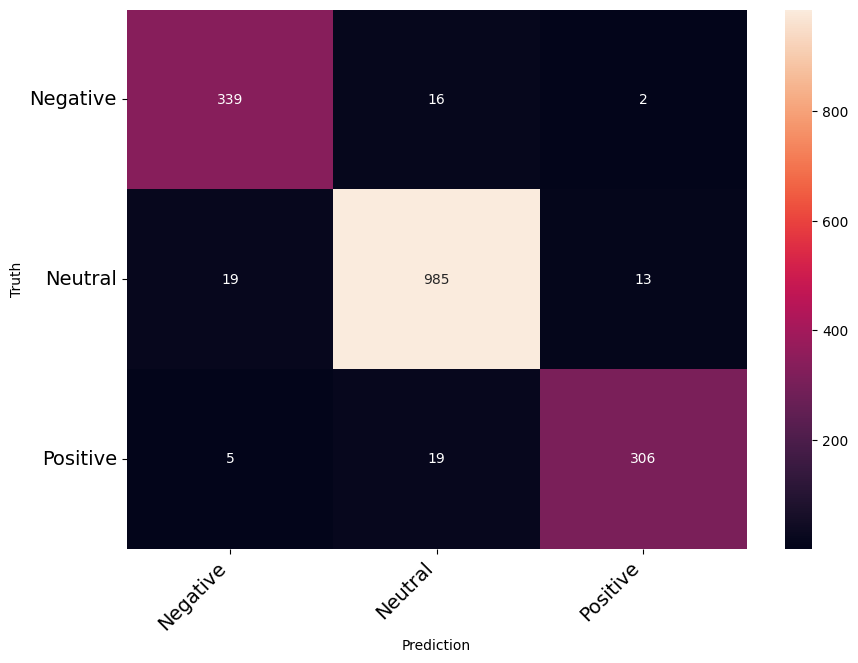

In [40]:
print_confusion_matrix(confusion_matrix(result_ft_BERT['label'], result_ft_BERT['Prediction']), ['Negative', 'Neutral', 'Positive'])

In [41]:
torch.cuda.empty_cache() # 這一步很重要